In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [13]:
pickle_in = open("../data/oxygen.pickle", "rb")
oxygen = pickle.load(pickle_in)
oxygen.describe()

,Year,Yday,Hour,PRESSURE,TEMPERATURE_VALUE,SALINITY_VALUE,OXYGEN_VALUE
count,1.297000e+04,1.297000e+04,12970.000000,1.297000e+04,1.297000e+04,1.297000e+04,12970.000000
mean,-8.204386e-15,1.314805e-16,0.000000,8.765369e-18,4.908607e-16,4.382685e-15,218.042145
std,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,23.011995
min,-2.068154e+00,-1.740584e+00,-0.035143,-1.160867e+00,-3.063763e+00,-2.152486e+01,109.900000
25%,-7.616786e-01,-8.740841e-01,-0.035143,-6.733490e-01,-7.213280e-01,-4.605411e-01,199.690000
50%,6.971469e-02,3.050335e-02,-0.035143,-1.858306e-01,-1.073420e-01,1.113958e-01,222.920000
75%,7.823375e-01,8.684370e-01,-0.035143,5.454471e-01,6.431659e-01,5.981507e-01,234.980000
max,1.732501e+00,1.725415e+00,28.452813,6.151909e+00,3.317628e+00,3.074516e+00,324.320000


In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

/home/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", n

In [14]:
## Train test split
train_dataset = oxygen.sample(frac=0.8, random_state=0)
test_dataset  = oxygen.drop(train_dataset.index)

In [15]:
train_dataset.head()

,Year,Yday,Hour,PRESSURE,TEMPERATURE_VALUE,SALINITY_VALUE,OXYGEN_VALUE
1859,-1.355531,0.563734,-0.035143,0.667327,-0.870289,-0.661327,213.98
6820,0.069715,1.154096,-0.035143,-0.673349,-0.650527,-0.131982,265.80
9274,0.544797,1.239794,-0.035143,0.301688,-0.949072,-0.636990,182.71
11109,0.901108,-0.102804,-0.035143,-0.917108,0.564383,0.214831,227.83
10251,0.782337,-0.569381,-0.035143,6.151909,-2.267644,-2.352801,202.81


In [16]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [17]:
train_labels = train_dataset.pop('OXYGEN_VALUE')
test_labels = test_dataset.pop('OXYGEN_VALUE')

### The Model

In [18]:
def build_model():
    model = keras.Sequential([
      layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
      layers.Dense(64, activation='relu'),
      layers.Dense(8, activation='relu'),
      layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam()
    
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae', 'mse', tf.keras.metrics.MeanAbsolutePercentageError()])
    
    return model

In [19]:
model = build_model()

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                448       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 5,137
Trainable params: 5,137
Non-trainable params: 0
_________________________________________________________________


In [25]:
## Train the model
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

In [26]:
pd.DataFrame(history.history).describe()

,loss,mae,mse,mean_absolute_percentage_error,val_loss,val_mae,val_mse,val_mean_absolute_percentage_error
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,124.105141,8.044875,124.105143,3.772340,133.628096,8.503744,133.628095,3.946359
std,5.019757,0.177361,5.019758,0.083227,4.749098,0.212164,4.749098,0.099593
min,115.998774,7.751125,115.998795,3.634219,125.249854,8.130034,125.249855,3.764160
25%,120.222926,7.905116,120.222910,3.706797,130.151139,8.348971,130.151138,3.875533
50%,122.832589,7.999689,122.832600,3.750814,133.008074,8.473672,133.008087,3.930791
75%,127.342597,8.157766,127.342588,3.824708,136.167953,8.608869,136.167953,4.002208
max,138.215576,8.559223,138.215591,4.012484,165.588207,9.861861,165.588226,4.612249


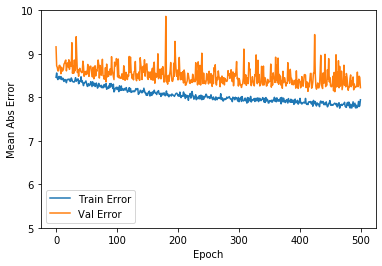

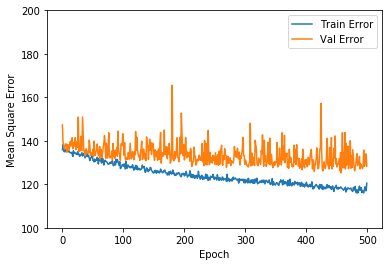

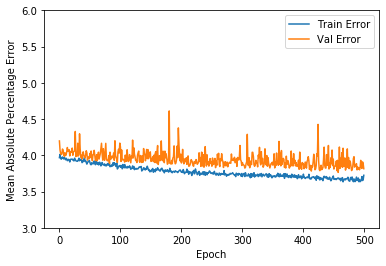

In [39]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([5,10])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([100,200])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
  plt.ylim([3,6])
  plt.legend()
  plt.show()


plot_history(history)

In [33]:
loss, mae, mse, mape = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Percentage Error: {:5.2f}".format(mape))

2594/2594 - 0s - loss: 138.2379 - mae: 8.3196 - mse: 138.2379 - mean_absolute_percentage_error: 3.9170
Testing set Mean Abs Percentage Error:  3.92


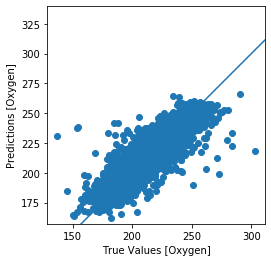

In [32]:
## Make predictions
test_predictions = model.predict(test_dataset).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Oxygen]')
plt.ylabel('Predictions [Oxygen]')
plt.axis('equal')
plt.axis('square')
_ = plt.plot([-300, 500], [-300, 500])

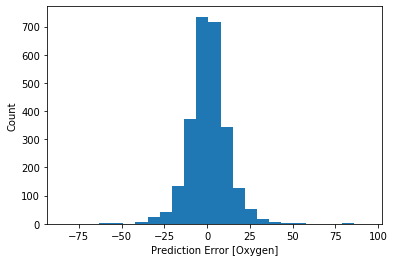

In [34]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Oxygen]")
_ = plt.ylabel("Count")

In [36]:
## Save model
model.save('../data/saved_models/oxygen_model.h5')